In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")
# Pretty plotting defaults (but no explicit colors)
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['grid.linewidth'] = 0.5


# Analysis 

## Basic Analysis 

In [3]:
df = pd.read_csv('Bitcoin.csv')
df.head(10)


,Date,Close,High,Low,Open,Volume
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
5,2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600
6,2014-09-23,435.790985,441.557007,396.196991,402.092010,45099500
7,2014-09-24,423.204987,436.112000,421.131989,435.751007,30627700
8,2014-09-25,411.574005,423.519989,409.467987,423.156006,26814400
9,2014-09-26,404.424988,414.937988,400.009003,411.428986,21460800


In [4]:
df.shape

(4102, 6)

In [5]:
df.dtypes

Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

In [6]:
df.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [7]:
# Cell 4: Standardize column names & convert Date to datetime
df.columns = [c.strip().lower() for c in df.columns]


In [8]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

In [9]:
df.describe()

,close,high,low,open,volume
count,4102.000000,4102.000000,4102.000000,4102.000000,4.102000e+03
mean,26519.151504,27033.620680,25930.715292,26497.702198,2.152577e+10
std,31413.340581,31940.136316,30822.002295,31399.721663,2.286455e+10
min,178.102997,211.731003,171.509995,176.897003,5.914570e+06
25%,2656.817383,2759.530029,2549.802551,2620.280090,1.209615e+09
50%,10667.725586,10914.121094,10319.602051,10637.568359,1.699237e+10
75%,41783.284180,42544.363281,40675.856445,41729.811523,3.295454e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


In [10]:
dups = df.duplicated(subset=['date']).sum()
int(dups)

0

In [11]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.dtypes

date      datetime64[ns]
close            float64
high             float64
low              float64
open             float64
volume             int64
dtype: object

In [12]:
df.set_index('date')

,close,high,low,open,volume
date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-12-05,89387.757812,92702.640625,88152.140625,92133.648438,63256398633
2025-12-06,89272.375000,90267.460938,88951.664062,89389.359375,37994042405
2025-12-07,90405.640625,91740.843750,87799.562500,89277.812500,47394898960


## Static Analysis 

In [13]:
start_date = df['date'].min()
end_date = df['date'].max()
n_days = (end_date - start_date).days

print(f"Range: {start_date.date()} to {end_date.date()} ({n_days} days)")


Range: 2014-09-17 to 2025-12-09 (4101 days)


In [14]:
    # Daily returns
    # pct_change() calculates how much the value changed from the previous row in percentage form.abs
    # How much Bitcoin went up or down compared to yesterday.
    df['daily_return'] = df['close'].pct_change()
    df['daily_return'].describe()


count    4101.000000
mean        0.001922
std         0.035259
min        -0.371695
25%        -0.012508
50%         0.001226
75%         0.016211
max         0.252472
Name: daily_return, dtype: float64

## Seasonal  And Static Analysis 

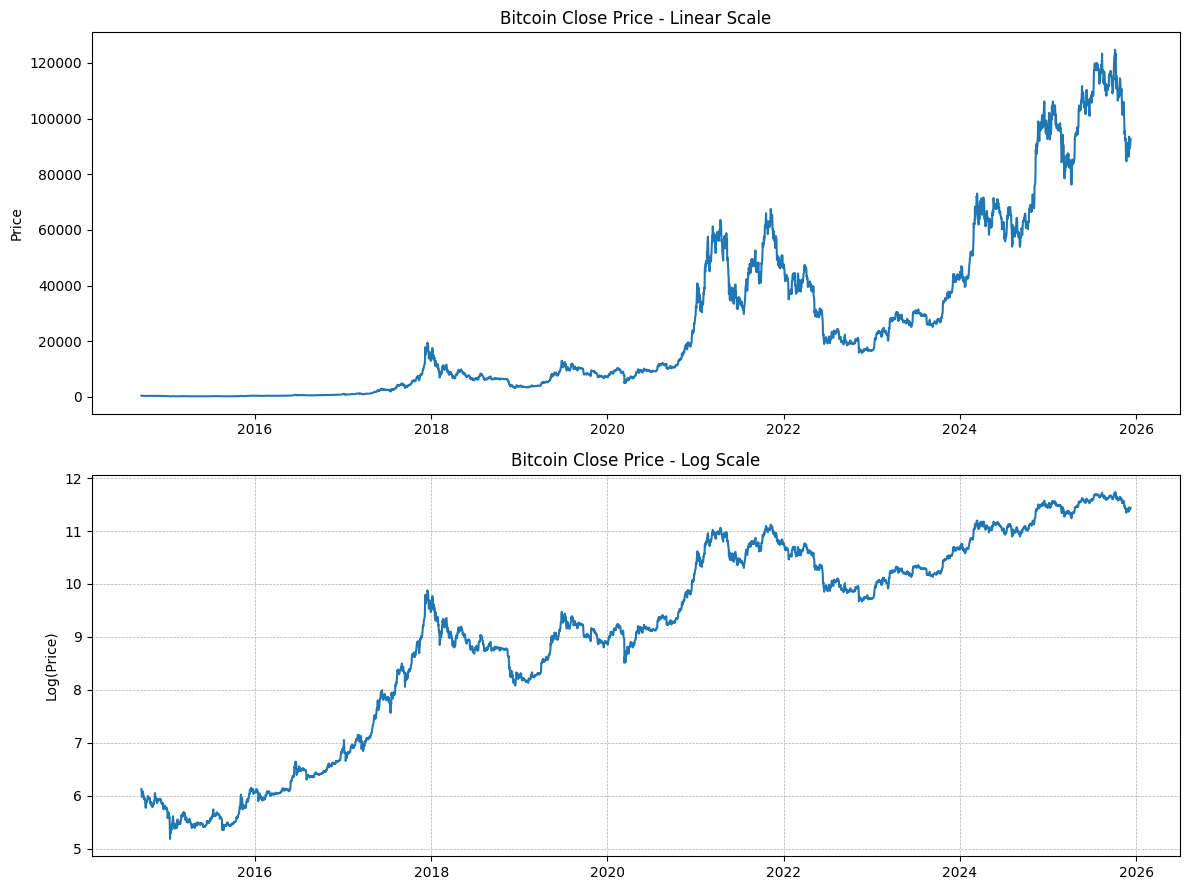

In [15]:
# Cell 11: Plot price trend (linear + log scale)
# why log scale?
# We use log scale to clearly see % growth and trends over time, even when prices change a lot. in normal small chnages looks flat!
fig, ax = plt.subplots(2,1, figsize=(12,9))
ax[0].plot(df['date'], df['close'])
plt.grid(True, which="both", ls="--")
ax[0].set_title('Bitcoin Close Price - Linear Scale')
ax[0].set_ylabel('Price')

ax[1].plot(df['date'], np.log(df['close']))
ax[1].set_title('Bitcoin Close Price - Log Scale')
ax[1].set_ylabel('Log(Price)')
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


In [16]:
# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,close,high,low,open,volume,daily_return,year,month
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,NaN,2014,9
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-0.071926,2014,9
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-0.069843,2014,9
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,0.035735,2014,9
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-0.024659,2014,9


### Yearly summary: first, last, mean, max, min, % change

In [17]:

yearly = df.groupby('year')['close'].agg(['first','last','mean','max','min'])
yearly['pct_change_year'] = (yearly['last'] - yearly['first']) / yearly['first'] * 100
display(yearly)

,first,last,mean,max,min,pct_change_year
year,,,,,,
2014,457.334015,320.192993,363.693085,457.334015,310.737000,-29.987059
2015,314.248993,430.566986,272.453381,465.321014,178.102997,37.014595
2016,434.334015,963.742981,568.492407,975.921021,364.330994,121.889824
2017,998.325012,14156.400391,4006.033629,19497.400391,777.757019,1318.015197
2018,13657.200195,3742.700439,7572.298947,17527.000000,3236.761719,-72.595405
2019,3843.520020,7193.599121,7395.246282,13016.231445,3399.471680,87.161745
2020,7200.174316,29001.720703,11116.378092,29001.720703,4970.788086,302.791925
2021,29374.152344,46306.445312,47436.932021,67566.828125,29374.152344,57.643512
2022,47686.812500,16547.496094,28197.754099,47686.812500,15787.284180,-65.299639


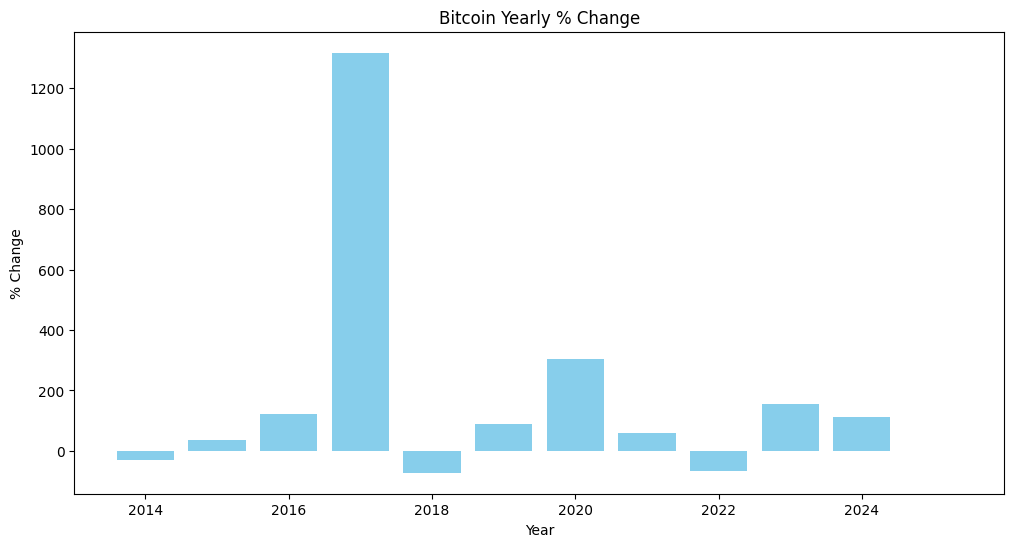

In [18]:
plt.figure(figsize=(12,6))
plt.bar(yearly.index, yearly['pct_change_year'], color='skyblue')
plt.title("Bitcoin Yearly % Change")
plt.xlabel("Year")
plt.ylabel("% Change")
plt.show()


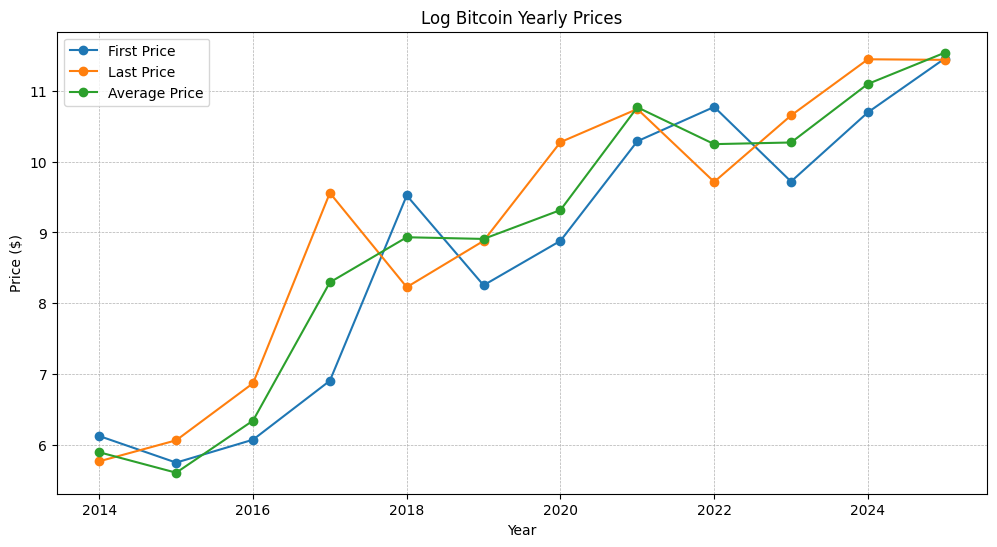

In [19]:
plt.figure(figsize=(12,6))
plt.plot(yearly.index, np.log(yearly['first']), marker='o', label='First Price')
plt.plot(yearly.index, np.log(yearly['last']), marker='o', label='Last Price')
plt.plot(yearly.index, np.log(yearly['mean']), marker='o', label='Average Price')
plt.title("Log Bitcoin Yearly Prices")
plt.xlabel("Year")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

### Monthly seasonality

In [20]:
# Monthly summary: mean, max, min
monthly = df.groupby(['year','month'])['close'].agg(['mean','max','min'])

print("Monthly sample (first 12 rows):")
display(monthly.head(12))

Monthly sample (first 12 rows):


mean         max         min
year month                                    
2014 9      407.182428  457.334015  375.467010
     10     364.148873  400.869995  320.510010
     11     366.099799  423.561005  325.748993
     12     341.267871  381.315002  310.737000
2015 1      248.782547  315.032013  178.102997
     2      234.153645  257.321014  217.110992
     3      269.042259  296.378998  242.712997
     4      235.491534  260.597992  219.158997
     5      236.997001  243.863007  229.781998
     6      238.081766  263.071991  222.880997
     7      279.563740  310.867004  255.412003
     8      250.733805  285.217987  210.494995

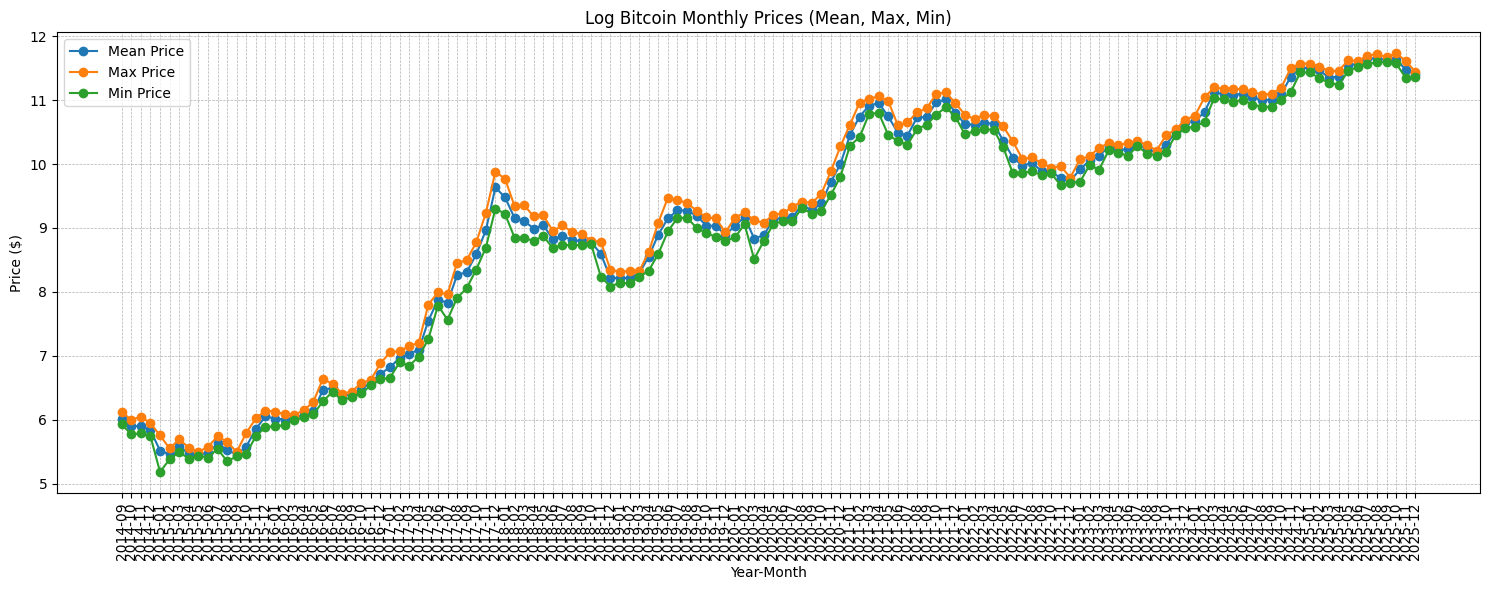

In [21]:
# Unpack the multi-index
years, months = zip(*monthly.index)
x_labels = [f"{y}-{m:02d}" for y, m in zip(years, months)]  # create 'YYYY-MM' labels

plt.figure(figsize=(15,6))
plt.plot(x_labels, np.log(monthly['mean']), marker='o', label='Mean Price')
plt.plot(x_labels, np.log(monthly['max']), marker='o', label='Max Price')
plt.plot(x_labels, np.log(monthly['min']), marker='o', label='Min Price')

plt.title("Log Bitcoin Monthly Prices (Mean, Max, Min)")
plt.xlabel("Year-Month")
plt.ylabel("Price ($)")
plt.xticks(rotation=90)  # Rotate for readability
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

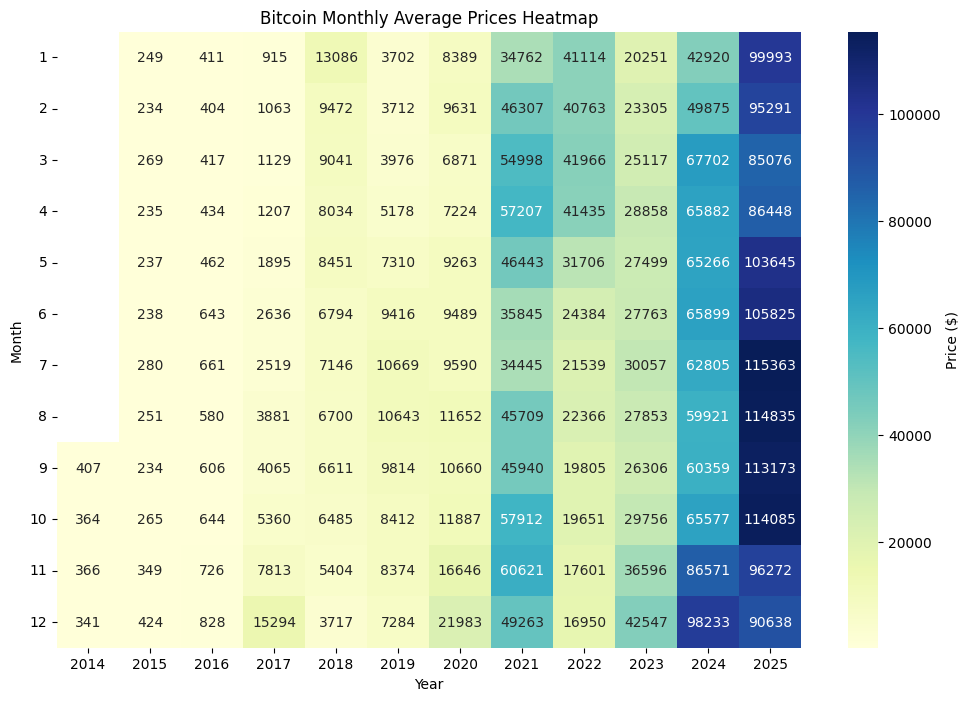

In [22]:
# Use the 'mean' column and unstack the MultiIndex
monthly_heatmap = monthly['mean'].unstack(level=0)  # rows = month, columns = year

plt.figure(figsize=(12,8))
sns.heatmap(monthly_heatmap, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Price ($)'})
plt.title("Bitcoin Monthly Average Prices Heatmap")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(rotation=0)  # Keep month labels horizontal
plt.show()

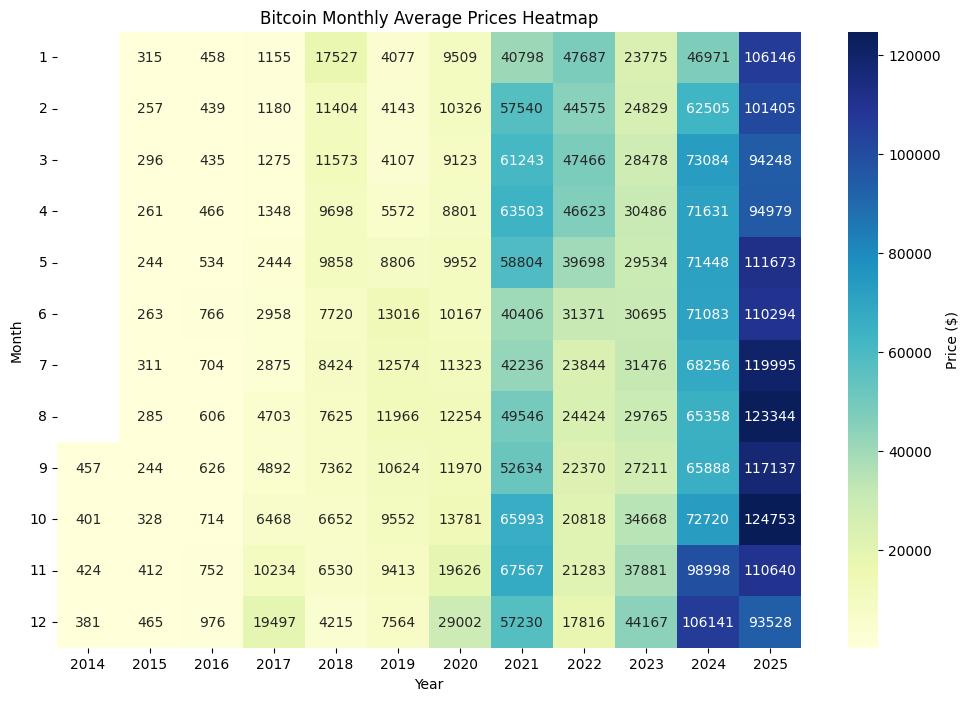

In [23]:
# Use the 'mean' column and unstack the MultiIndex
monthly_heatmap = monthly['max'].unstack(level=0)  # rows = month, columns = year

plt.figure(figsize=(12,8))
sns.heatmap(monthly_heatmap, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Price ($)'})
plt.title("Bitcoin Monthly Average Prices Heatmap")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(rotation=0)  # Keep month labels horizontal
plt.show()

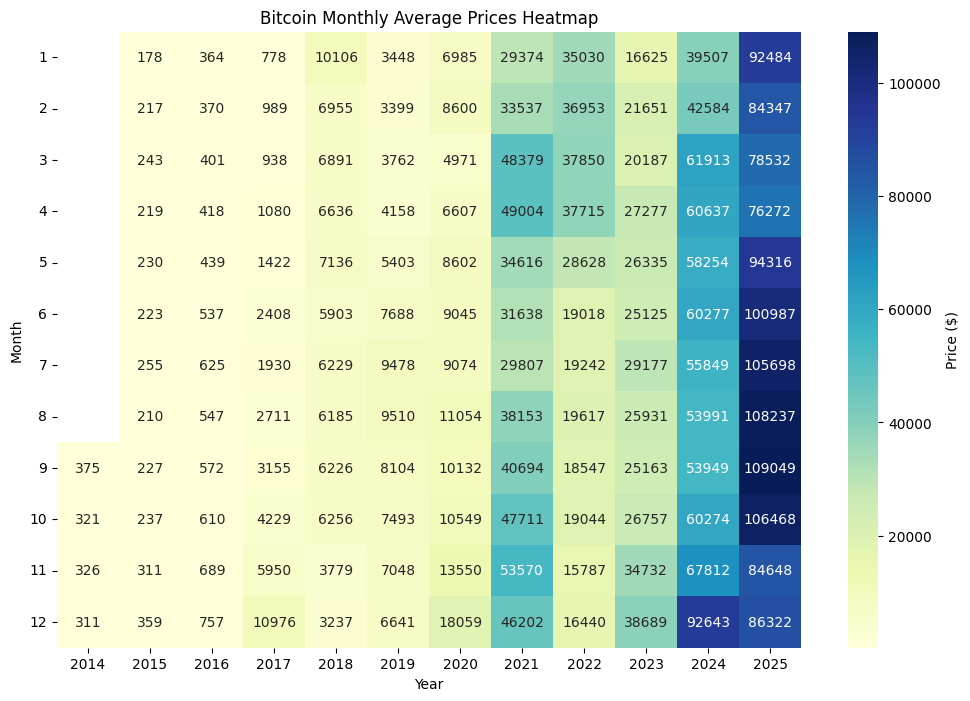

In [24]:
# Use the 'mean' column and unstack the MultiIndex
monthly_heatmap = monthly['min'].unstack(level=0)  # rows = month, columns = year

plt.figure(figsize=(12,8))
sns.heatmap(monthly_heatmap, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Price ($)'})
plt.title("Bitcoin Monthly Average Prices Heatmap")
plt.xlabel("Year")
plt.ylabel("Month")
plt.yticks(rotation=0)  # Keep month labels horizontal
plt.show()

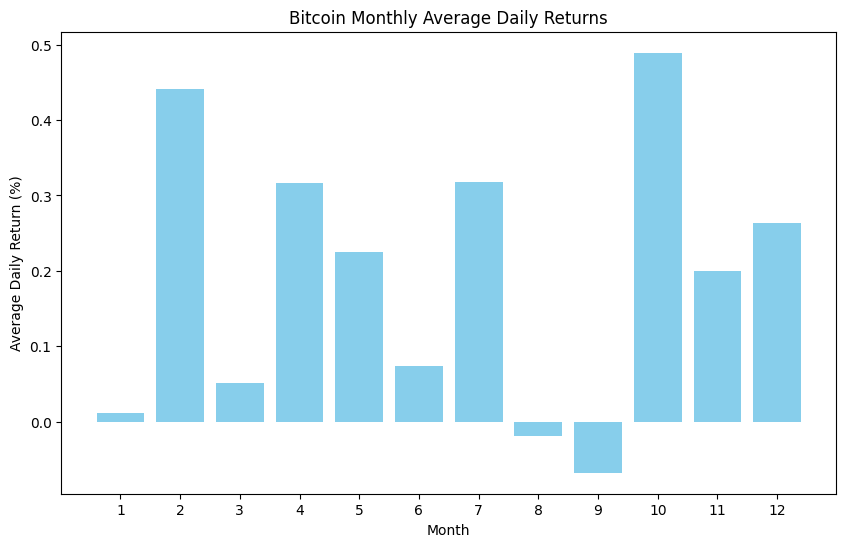

In [25]:
## it shows which months tend to have higher or lower average daily returns for Bitcoin.

monthly_by_month_sorted = df.groupby('month')['daily_return'].mean()
monthly_by_month_pct = monthly_by_month_sorted *100  # convert to percentage

plt.figure(figsize=(10,6))
plt.bar(monthly_by_month_pct.index, monthly_by_month_pct.values, color='skyblue')
plt.title("Bitcoin Monthly Average Daily Returns")
plt.xlabel("Month")
plt.ylabel("Average Daily Return (%)")
plt.xticks(range(1,13))  
plt.show()

### Weekly pattern (weekday returns)

In [26]:
# 1️⃣ Weekday stats
df['weekday'] = df['date'].dt.day_name()
weekday_stats = df.groupby('weekday')['daily_return'].agg(['mean','std','count']).reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).reset_index()
weekday_stats['mean_return_pct'] = weekday_stats['mean'] * 100
display(weekday_stats)

,weekday,mean,std,count,mean_return_pct
0,Monday,0.004843,0.038179,586,0.484274
1,Tuesday,0.000827,0.035593,586,0.082692
2,Wednesday,0.002811,0.038464,585,0.281064
3,Thursday,0.000324,0.042274,586,0.032360
4,Friday,0.001980,0.034605,586,0.197964
5,Saturday,0.001849,0.027233,586,0.184856
6,Sunday,0.000825,0.027768,586,0.082503


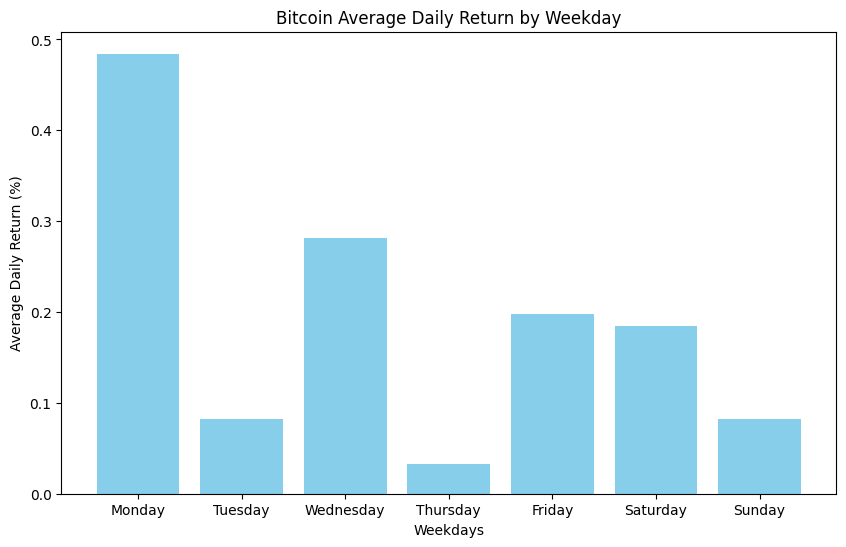

In [27]:
# 3️⃣ Bar chart of average daily return
plt.figure(figsize=(10,6))
plt.bar(weekday_stats['weekday'], weekday_stats['mean_return_pct'], color='skyblue')
plt.title("Bitcoin Average Daily Return by Weekday")
plt.xlabel("Weekdays")
plt.ylabel("Average Daily Return (%)")
plt.show()

### Daily volatility & rolling volatilities

In [28]:
# 1️⃣ Daily volatility (high-low / close * 100)
df['daily_volatility_pct'] = (df['high'] - df['low']) / df['close'] * 100


In [29]:
# 2️⃣ Rolling volatilities
df['vol_7d'] = df['daily_volatility_pct'].rolling(7).std()
df['vol_30d'] = df['daily_volatility_pct'].rolling(30).std()
display(df[['date','daily_volatility_pct','vol_7d','vol_30d']].dropna().tail())

,date,daily_volatility_pct,vol_7d,vol_30d
4097,2025-12-05,5.090742,2.456698,1.860048
4098,2025-12-06,1.473913,2.366584,1.924678
4099,2025-12-07,4.359552,2.113730,1.922801
4100,2025-12-08,2.893006,1.689597,1.890422
4101,2025-12-09,5.409970,1.370946,1.902598


In [30]:
# 3️⃣ Display last few rows
display(df[['date','daily_volatility_pct','vol_7d','vol_30d']].dropna().tail())

,date,daily_volatility_pct,vol_7d,vol_30d
4097,2025-12-05,5.090742,2.456698,1.860048
4098,2025-12-06,1.473913,2.366584,1.924678
4099,2025-12-07,4.359552,2.113730,1.922801
4100,2025-12-08,2.893006,1.689597,1.890422
4101,2025-12-09,5.409970,1.370946,1.902598


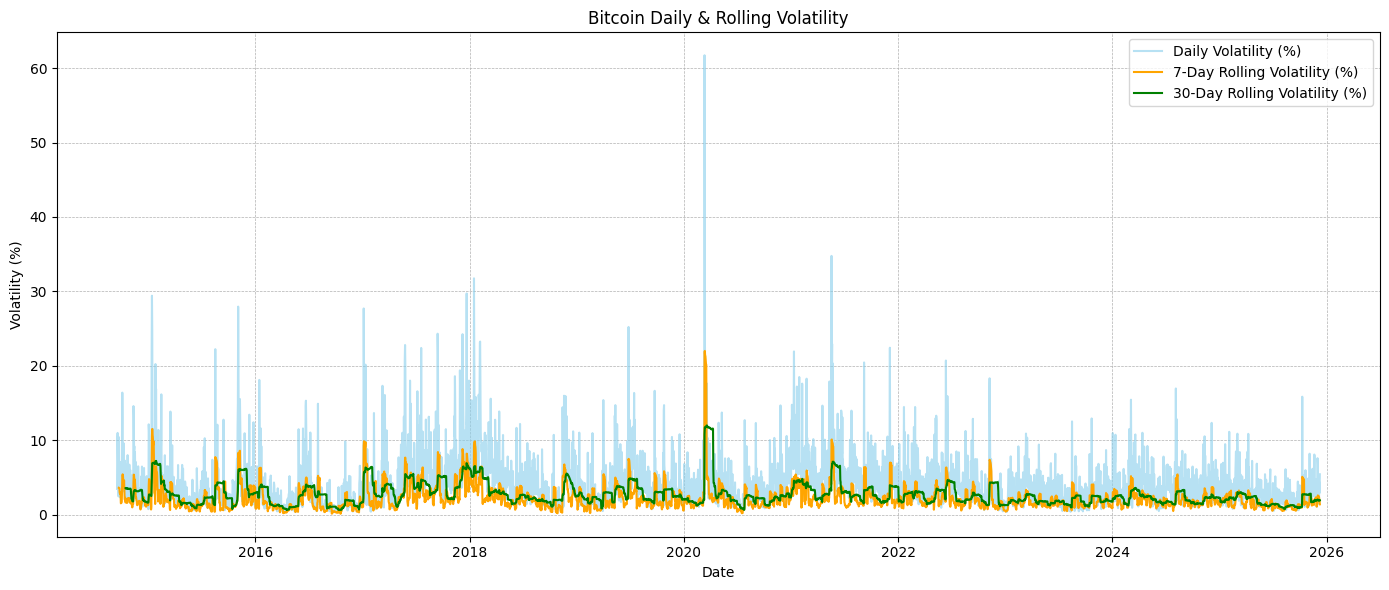

In [31]:
# 4️⃣ Plot daily and rolling volatilities
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['daily_volatility_pct'], label='Daily Volatility (%)', color='skyblue', alpha=0.6)
plt.plot(df['date'], df['vol_7d'], label='7-Day Rolling Volatility (%)', color='orange')
plt.plot(df['date'], df['vol_30d'], label='30-Day Rolling Volatility (%)', color='green')
plt.title("Bitcoin Daily & Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [32]:
# Cell 16: Top extreme volatility days
top_vol_days = df[['date','daily_volatility_pct','close']].nlargest(10, 'daily_volatility_pct')
top_vol_days


,date,daily_volatility_pct,close
2003,2020-03-12,61.735929,4970.788086
2436,2021-05-19,34.766952,37002.441406
1217,2018-01-16,31.749699,11490.500000
2004,2020-03-13,31.114755,5563.707031
1192,2017-12-22,29.717032,13831.799805
119,2015-01-14,29.412196,178.102997
413,2015-11-04,27.945663,411.562988
841,2017-01-05,27.697703,1013.380005
1744,2019-06-27,25.210952,11182.806641
120,2015-01-15,24.861325,209.843994


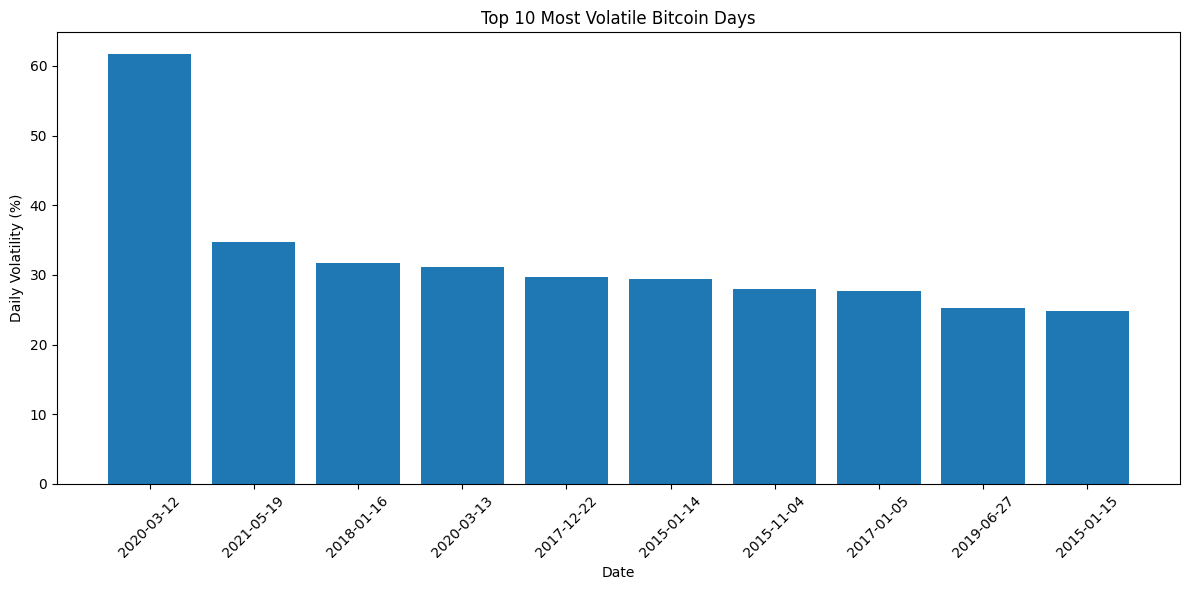

In [33]:
plt.figure(figsize=(12,6))
plt.bar(top_vol_days['date'].dt.strftime('%Y-%m-%d'), top_vol_days['daily_volatility_pct'])
plt.title("Top 10 Most Volatile Bitcoin Days")
plt.xlabel("Date")
plt.ylabel("Daily Volatility (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top volume days and trend

In [34]:
top_vol = df[['date','volume','close']].nlargest(10, 'volume')
display(top_vol)

,date,volume,close
2354,2021-02-26,350967941479,46339.761719
3953,2025-07-14,181746419401,119849.703125
4041,2025-10-10,153125018868,113214.367188
3732,2024-12-05,149218945580,96593.570312
3709,2024-11-12,133673285375,87955.812500
4083,2025-11-21,129157506112,85090.687500
2436,2021-05-19,126358098747,37002.441406
3778,2025-01-20,126279678351,102016.664062
3710,2024-11-13,123559027869,90584.164062
2308,2021-01-11,123320567399,35566.656250


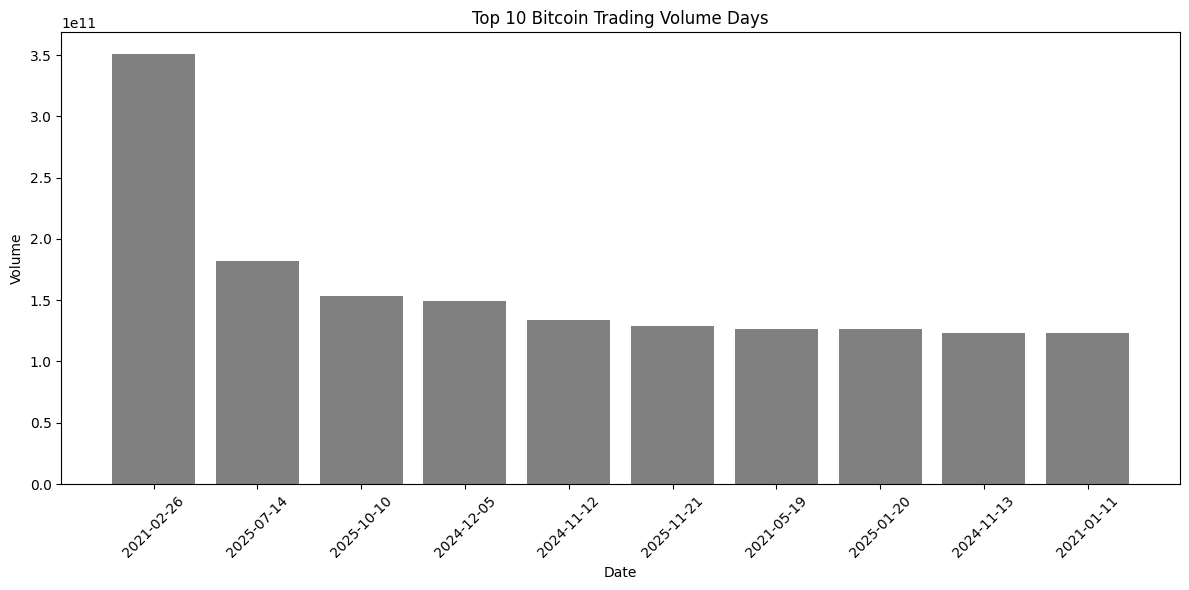

In [35]:
plt.figure(figsize=(12,6))
plt.bar(top_vol['date'].dt.strftime('%Y-%m-%d'), top_vol['volume'], color='grey')
plt.title("Top 10 Bitcoin Trading Volume Days")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

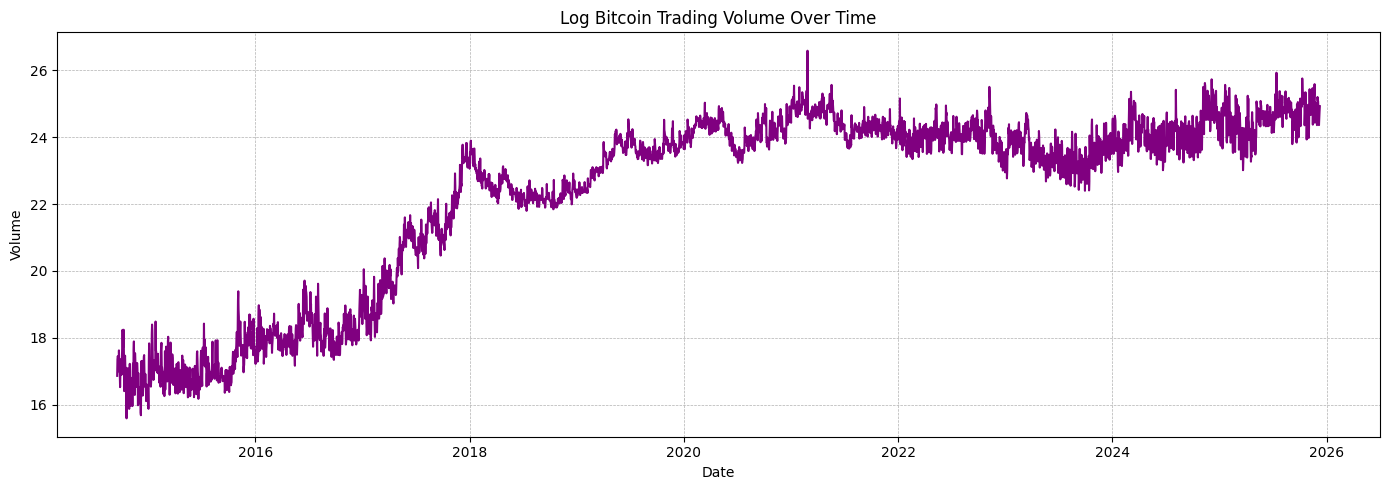

In [36]:
plt.figure(figsize=(14,5))
plt.plot(df['date'], np.log(df['volume']), color='purple')
plt.title('Log Bitcoin Trading Volume Over Time')
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [37]:
#It shows the worst loss an investor would have suffered if bought at a peak and sold at the bottom.
# Make sure data is sorted by date
df = df.sort_values('date').reset_index(drop=True)

In [38]:
# cummax() track highest price down in rows
df['cum_max'] = df['close'].cummax()

In [39]:
# Calculate drawdown
df['drawdown'] = (df['close'] - df['cum_max']) / df['cum_max']

In [40]:
# 3️⃣ Find maximum drawdown and when it happened
max_drawdown = df['drawdown'].min()
max_drawdown_date = df.loc[df['drawdown'].idxmin(), 'date']

print(f"Max drawdown: {max_drawdown:.2%} on {max_drawdown_date.date()}")

Max drawdown: -83.40% on 2018-12-15


In [41]:
df.isnull().sum()

date                     0
close                    0
high                     0
low                      0
open                     0
volume                   0
daily_return             1
year                     0
month                    0
weekday                  0
daily_volatility_pct     0
vol_7d                   6
vol_30d                 29
cum_max                  0
drawdown                 0
dtype: int64

## Stationarity Test 

In [42]:
# ADF TEST 

return_series = df['daily_return'].dropna()

# 1️⃣ ADF test on close prices
result_close = adfuller(df['close'])
stat_close = result_close[0]
p_close = result_close[1]

if p_close < 0.05:
    print(f"Close Prices: Stationary")
else:
    print(f"Close Prices: Non-Stationary")


Close Prices: Non-Stationary


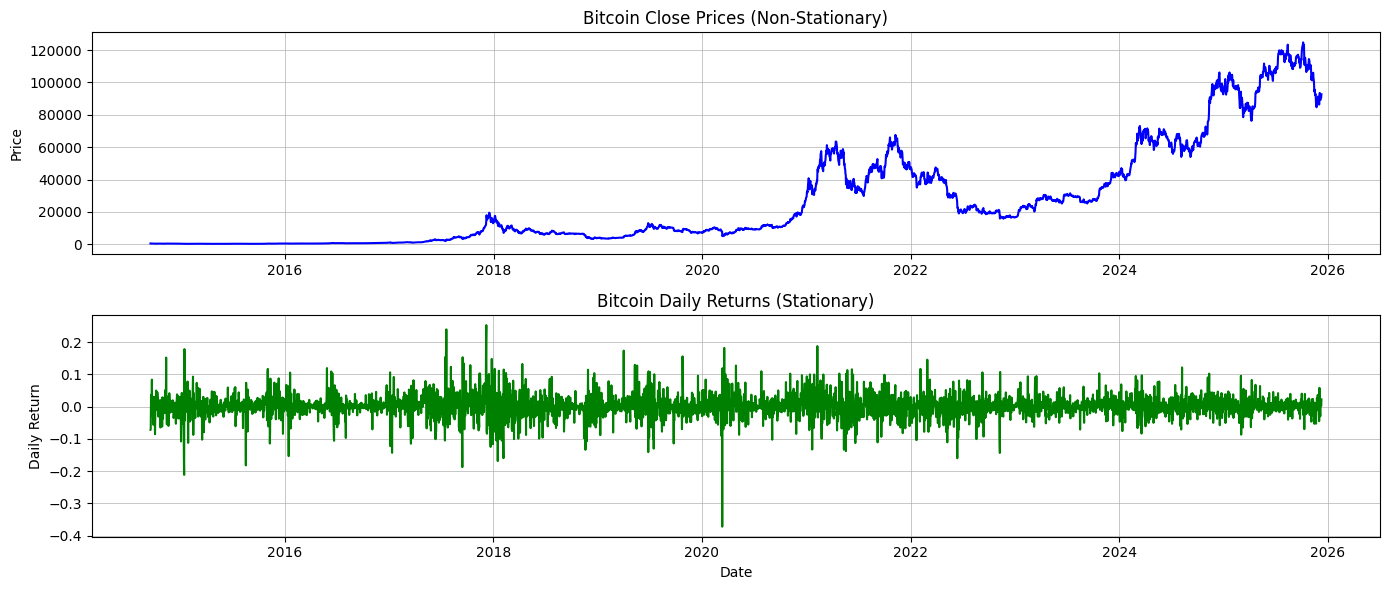

In [43]:
plt.figure(figsize=(14,6))

# Plot Close Prices
plt.subplot(2,1,1)
plt.plot(df['date'], df['close'], color='blue')
plt.title("Bitcoin Close Prices (Non-Stationary)")
plt.ylabel("Price")
plt.grid(True)

# Plot Daily Returns
plt.subplot(2,1,2)
plt.plot(df['date'], df['daily_return'], color='green')
plt.title("Bitcoin Daily Returns (Stationary)")
plt.ylabel("Daily Return")
plt.xlabel("Date")
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
df.isnull().sum()

date                     0
close                    0
high                     0
low                      0
open                     0
volume                   0
daily_return             1
year                     0
month                    0
weekday                  0
daily_volatility_pct     0
vol_7d                   6
vol_30d                 29
cum_max                  0
drawdown                 0
dtype: int64

#### UNDERSTANDT THE CODE WHY ADF AND PACF IS USED

##  Time series decomposition

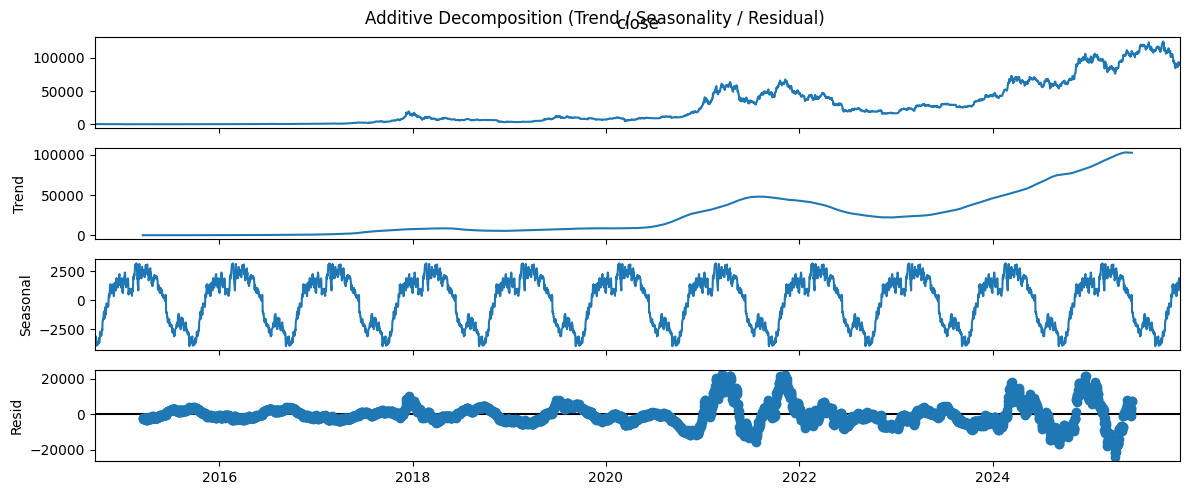

In [45]:

ts = df.set_index('date')['close'].asfreq('D').fillna(method='ffill')
decomp = seasonal_decompose(ts, model='additive', period=365)
decomp.plot()
plt.suptitle('Additive Decomposition (Trend / Seasonality / Residual)')
plt.show()


In [46]:
df.isnull().sum()

date                     0
close                    0
high                     0
low                      0
open                     0
volume                   0
daily_return             1
year                     0
month                    0
weekday                  0
daily_volatility_pct     0
vol_7d                   6
vol_30d                 29
cum_max                  0
drawdown                 0
dtype: int64

## Moving Average 


In [47]:
# ---- SIMPLE MOVING AVERAGES ----
df['MA30'] = df['close'].rolling(30).mean()
df['MA200'] = df['close'].rolling(200).mean()

In [48]:
# ---- FIND GOLDEN & DEATH CROSS ----
df['Above'] = df['MA30'] > df['MA200']                # True = MA30 above MA200
df['Cross'] = df['Above'].ne(df['Above'].shift(1))    # Detects crossing moment

golden = df[(df['Cross']) & (df['Above'] == True)]
death  = df[(df['Cross']) & (df['Above'] == False)]

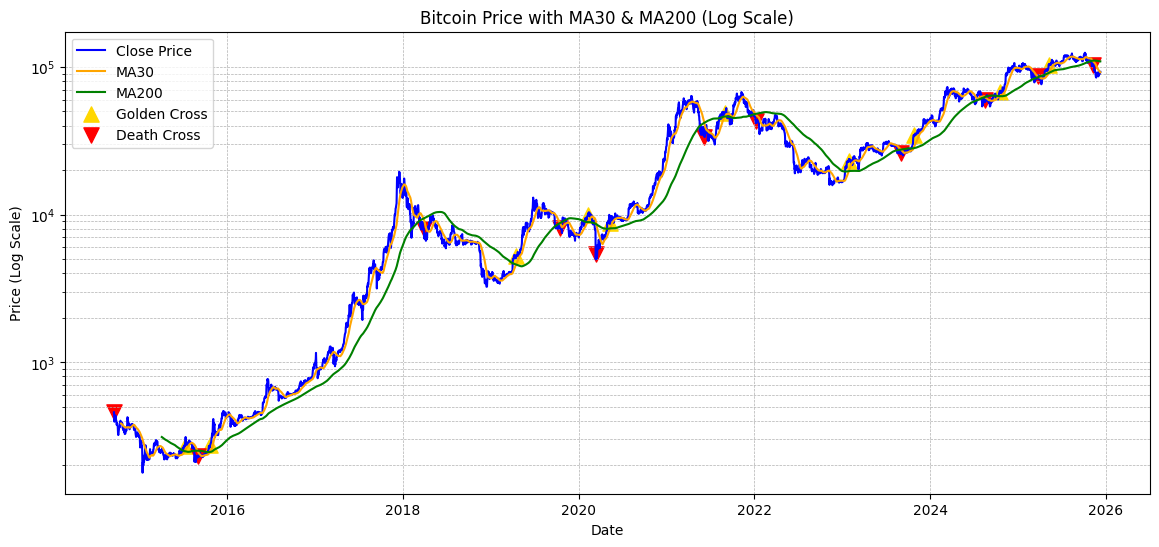

In [49]:
# ---- PLOT (Same as your previous one) ----
plt.figure(figsize=(14,6))

plt.plot(df['date'], df['close'], label='Close Price', color='blue')
plt.plot(df['date'], df['MA30'], label='MA30', color='orange')
plt.plot(df['date'], df['MA200'], label='MA200', color='green')

# Golden Cross points (▲)
plt.scatter(golden['date'], golden['close'],
            color='gold', marker='^', s=120, label='Golden Cross')

# Death Cross points (▼)
plt.scatter(death['date'], death['close'],
            color='red', marker='v', s=120, label='Death Cross')

plt.yscale('log')       # same as previous graph
plt.title("Bitcoin Price with MA30 & MA200 (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Price (Log Scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--")

plt.show()

In [50]:
df.dtypes

date                    datetime64[ns]
close                          float64
high                           float64
low                            float64
open                           float64
volume                           int64
daily_return                   float64
year                             int32
month                            int32
weekday                         object
daily_volatility_pct           float64
vol_7d                         float64
vol_30d                        float64
cum_max                        float64
drawdown                       float64
MA30                           float64
MA200                          float64
Above                             bool
Cross                             bool
dtype: object

In [51]:
# Highest close
highest = df.loc[df['close'].idxmax()]
print("Highest Close:")
print(f"Date: {highest['date'].date()}")
print(f"Close Price: ${highest['close']:.2f}")


Highest Close:
Date: 2025-10-06
Close Price: $124752.53


In [52]:
# Lowest close
lowest = df.loc[df['close'].idxmin()]
print("Lowest Close:")
print(f"Date: {lowest['date'].date()}")
print(f"Close Price: ${lowest['close']:.2f}")


Lowest Close:
Date: 2015-01-14
Close Price: $178.10


In [53]:
df.isnull().sum()

date                      0
close                     0
high                      0
low                       0
open                      0
volume                    0
daily_return              1
year                      0
month                     0
weekday                   0
daily_volatility_pct      0
vol_7d                    6
vol_30d                  29
cum_max                   0
drawdown                  0
MA30                     29
MA200                   199
Above                     0
Cross                     0
dtype: int64

# Phase 2 - Feature Engineering And Pre-Processing 

In [54]:
df['daily_return'] = df['daily_return'].fillna(0)
df['vol_7d'] = df['vol_7d'].fillna(df['vol_7d'].median())
df['vol_30d'] = df['vol_30d'].fillna(df['vol_30d'].median())
df['MA30'] = df['MA30'].fillna(method='bfill')
df['MA200'] = df['MA200'].fillna(method='bfill')
df.head()

,date,close,high,low,open,volume,daily_return,year,month,weekday,daily_volatility_pct,vol_7d,vol_30d,cum_max,drawdown,MA30,MA200,Above,Cross
0,2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,0.000000,2014,9,Wednesday,3.444313,1.745914,2.361547,457.334015,0.000000,384.112801,310.84317,False,True
1,2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-0.071926,2014,9,Thursday,10.309109,1.745914,2.361547,457.334015,-0.071926,384.112801,310.84317,False,False
2,2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-0.069843,2014,9,Friday,10.968444,1.745914,2.361547,457.334015,-0.136745,384.112801,310.84317,False,False
3,2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,0.035735,2014,9,Saturday,8.171354,1.745914,2.361547,457.334015,-0.105896,384.112801,310.84317,False,False
4,2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-0.024659,2014,9,Sunday,4.825472,1.745914,2.361547,457.334015,-0.127944,384.112801,310.84317,False,False


In [55]:
df.isnull().sum()

date                    0
close                   0
high                    0
low                     0
open                    0
volume                  0
daily_return            0
year                    0
month                   0
weekday                 0
daily_volatility_pct    0
vol_7d                  0
vol_30d                 0
cum_max                 0
drawdown                0
MA30                    0
MA200                   0
Above                   0
Cross                   0
dtype: int64

In [56]:
y = df['close']


In [57]:
df['log_return'] = np.log(df['close']).diff()
df = df.dropna()

In [58]:
model_columns = ['date', 'close', 'volume', 'daily_volatility_pct', 'log_return']


In [59]:
# PHASE 4 — CELL 1
df_model = df[['date', 'close', 'volume', 'daily_volatility_pct', 'log_return']].copy()
df_model.set_index('date', inplace=True)

print("INSIGHT: Reduced columns for short-term time series modeling.")
print(df_model.head())


INSIGHT: Reduced columns for short-term time series modeling.
                 close    volume  daily_volatility_pct  log_return
date                                                              
2014-09-18  424.440002  34483200             10.309109   -0.074643
2014-09-19  394.795990  37919700             10.968444   -0.072402
2014-09-20  408.903992  36863600              8.171354    0.035111
2014-09-21  398.821014  26580100              4.825472   -0.024968
2014-09-22  402.152008  24127600              2.433403    0.008317


In [60]:
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index]
test = df.iloc[split_index:]


# Model Training


In [61]:
# PHASE 4 — CELL 1
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


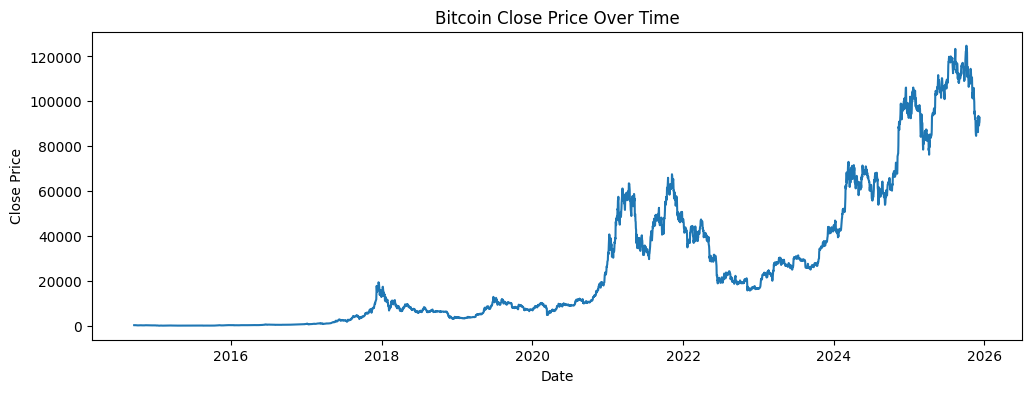

In [62]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['close'])
plt.title("Bitcoin Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


## As we have done so far adfuller test that shows close price column is non stationary for Time Series mode we have to make it stationary by differencing

In [63]:

adf_result = adfuller(ts)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

if adf_result[1] < 0.05:
    print("INSIGHT: Time series is stationary.")
else:
    print("INSIGHT: Time series is non-stationary → differencing needed for ARIMA.")

ADF Statistic: -0.6727
p-value: 0.8537
INSIGHT: Time series is non-stationary → differencing needed for ARIMA.


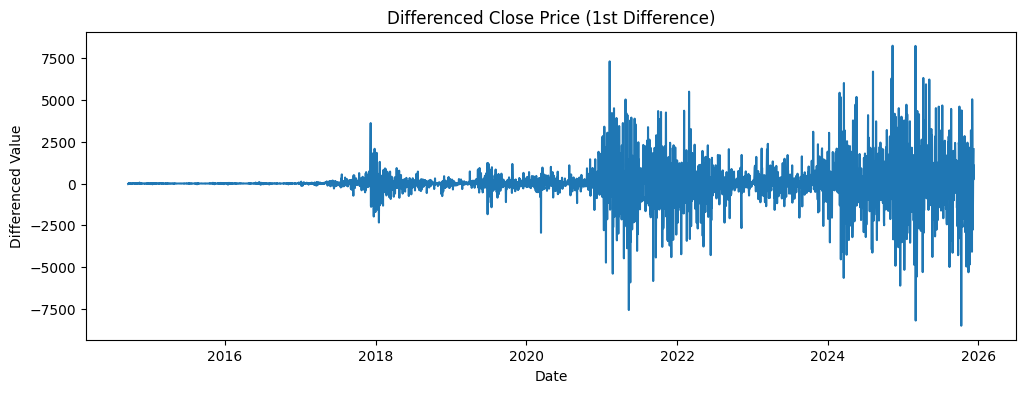

INSIGHT: First differencing applied to remove trend.


In [64]:
# PHASE 4 — CELL 4.1
# First-order differencing

ts_diff = ts.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(ts_diff)
plt.title("Differenced Close Price (1st Difference)")
plt.xlabel("Date")
plt.ylabel("Differenced Value")
plt.show()

print("INSIGHT: First differencing applied to remove trend.")


In [65]:
# PHASE 4 — CELL 4.2
adf_diff = adfuller(ts_diff)

print(f"ADF Statistic: {adf_diff[0]:.4f}")
print(f"p-value: {adf_diff[1]:.4f}")

if adf_diff[1] < 0.05:
    print("INSIGHT: Differenced series is now stationary.")
else:
    print("INSIGHT: Still non-stationary → consider second differencing.")


ADF Statistic: -9.6440
p-value: 0.0000
INSIGHT: Differenced series is now stationary.


<Figure size 1200x400 with 0 Axes>

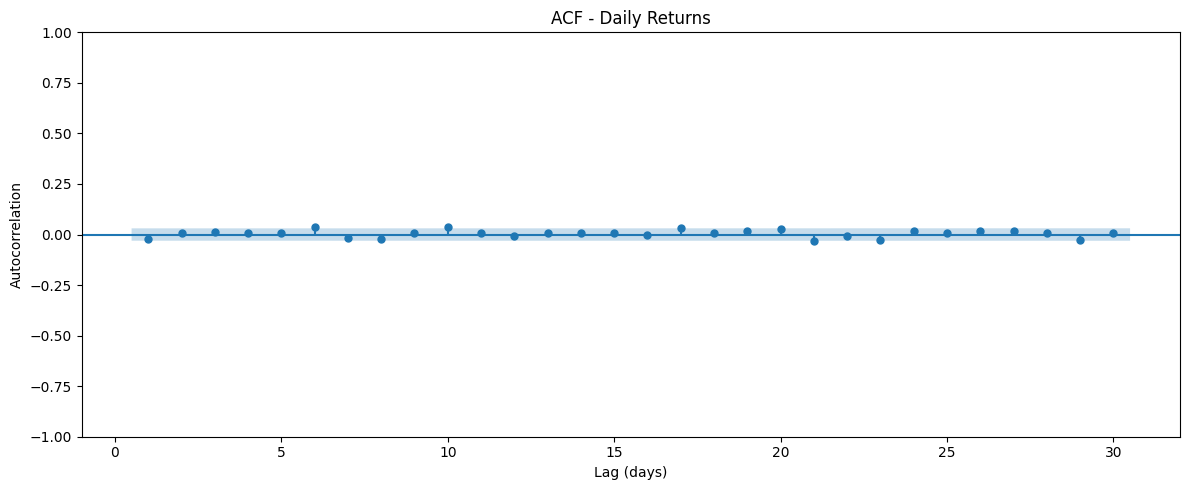

<Figure size 1200x400 with 0 Axes>

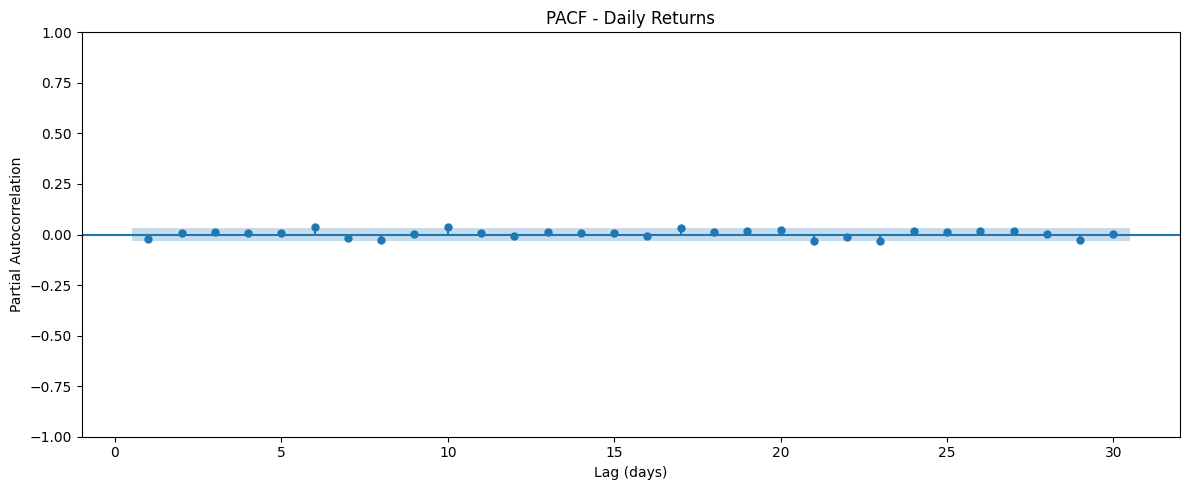

In [66]:

returns = df['daily_return'].dropna()

# 1️⃣ ACF plot
plt.figure(figsize=(12,4))
plot_acf(returns, lags=30, zero=False)
plt.title('ACF - Daily Returns')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

# 2️⃣ PACF plot
plt.figure(figsize=(12,4))
plot_pacf(returns, lags=30, zero=False, method='ywm')
plt.title('PACF - Daily Returns')
plt.xlabel('Lag (days)')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

In [67]:
df.isnull().sum()

date                    0
close                   0
high                    0
low                     0
open                    0
volume                  0
daily_return            0
year                    0
month                   0
weekday                 0
daily_volatility_pct    0
vol_7d                  0
vol_30d                 0
cum_max                 0
drawdown                0
MA30                    0
MA200                   0
Above                   0
Cross                   0
log_return              0
dtype: int64

In [68]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA
model = ARIMA(train['close'], order=(1,1,1))
result = model.fit()

print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 3280
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26493.666
Date:                Sat, 13 Dec 2025   AIC                          52993.332
Time:                        21:08:27   BIC                          53011.617
Sample:                             0   HQIC                         52999.879
                               - 3280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0917      0.351     -0.261      0.794      -0.779       0.596
ma.L1          0.0669      0.352      0.190      0.849      -0.623       0.756
sigma2      6.111e+05   4975.553    122.814      0.0

In [69]:
# Forecast future values (same length as test)
forecast = result.get_forecast(steps=len(test))

# Mean prediction
forecast_mean = forecast.predicted_mean

# Confidence intervals
conf_int = forecast.conf_int()


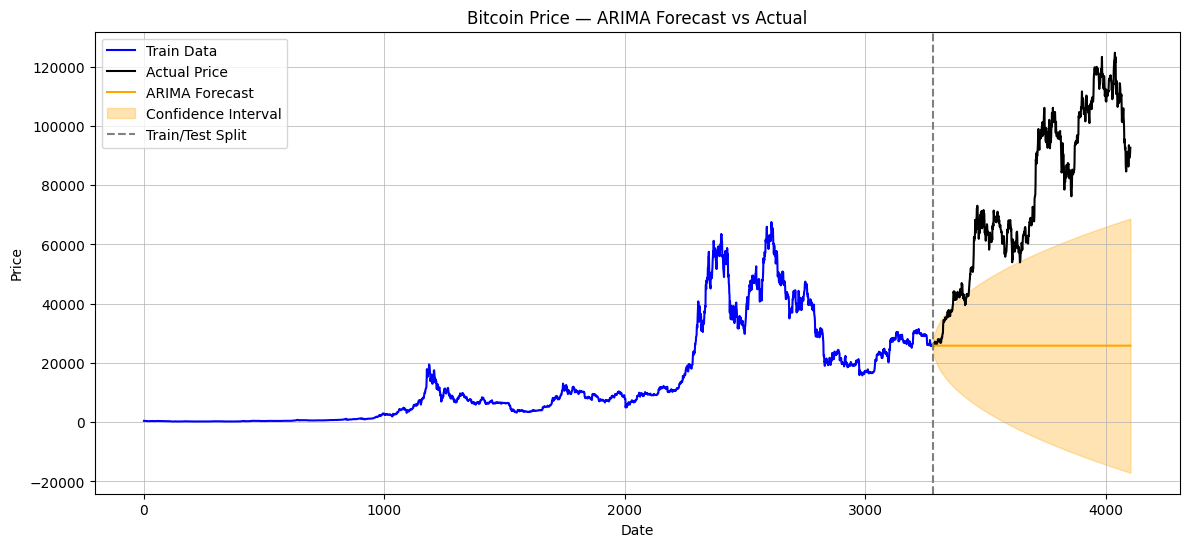

In [70]:

plt.figure(figsize=(14,6))

# Plot training data
plt.plot(train.index, train['close'], label='Train Data', color='blue')

# Plot actual test data
plt.plot(test.index, test['close'], label='Actual Price', color='black')

# Plot forecast
plt.plot(test.index, forecast_mean, label='ARIMA Forecast', color='orange')

# Confidence interval
plt.fill_between(
    test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='Confidence Interval'
)

# Vertical line for train/test split
plt.axvline(test.index[0], linestyle='--', color='gray', label='Train/Test Split')

plt.title('Bitcoin Price — ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [71]:
df['log_return'] = np.log(df['close']).diff()
df = df.dropna()
exog_cols = ['volume','vol_7d','vol_30d','daily_return']


In [72]:
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

# Target for SARIMAX
train_ret = train['log_return']
test_ret = test['log_return']


In [73]:
model = SARIMAX(
    train_ret,
    exog=train[exog_cols],
    order=(1,0,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit()


In [74]:
forecast_ret = result.get_forecast(steps=len(test_ret), exog=test[exog_cols]).predicted_mean

# Convert forecasted returns to prices
last_price = train['close'].iloc[-1]
price_forecast = last_price * np.exp(forecast_ret.cumsum())


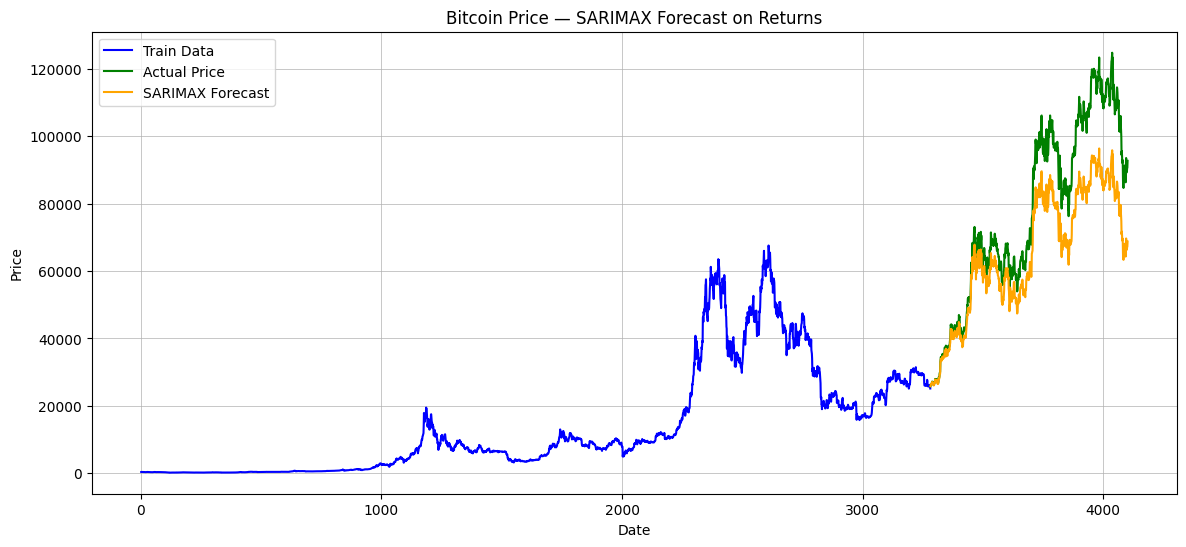

In [75]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train['close'], label='Train Data', color='blue')
plt.plot(test.index, test['close'], label='Actual Price', color='green')
plt.plot(test.index, price_forecast, label='SARIMAX Forecast', color='orange')
plt.title('Bitcoin Price — SARIMAX Forecast on Returns')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
